# Vector quantization

This is based on the new O'Reily feature engineering book. Push into the slides as follows:
- Illustrate use of sklearn featureunion in a pipe
- Plot decision boundaries and show linear/non-linear in X_1/X_2.
- Illustrate dimensionality of feature maps.

In [1]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
import scipy

# Model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegressionCV

# Featurizers
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
# Could also use RandomTreesEmbedding -- this isn't in the O'Reily book.
from sklearn.ensemble import RandomTreesEmbedding


# Plotting
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class KMeansFeaturizer(TransformerMixin):
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.
    """

    def __init__(self, k=100, random_state=None):
        self.k = k
        self.random_state = random_state
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.
        """
        # No target variable, just do plain k-means
        km_model = KMeans(n_clusters=self.k, 
                          n_init=20, 
                          random_state=self.random_state)
        km_model.fit(X)

        self.km_model = km_model
        self.enc = OneHotEncoder()
        self.enc.fit(km_model.predict(X).reshape(-1,1))
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.
        """
        clusters = self.km_model.predict(X)
        return self.enc.transform(clusters.reshape(-1,1))
    
class IdentityFeaturizer(TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self, X, y=None):
        return X

def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

In [2]:
# Generate some test data from the same distribution as training data

training_data, training_labels = make_moons(n_samples=2000, noise=0.3)
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

pipe = Pipeline([
    ('feats',FeatureUnion([
        ('kmeans', KMeansFeaturizer(k=100,random_state=2052018)),
        ('ID', IdentityFeaturizer())
    ])),
    ('clf', LogisticRegressionCV())
])

pipe.fit(training_data, training_labels)

compare = LogisticRegressionCV()
compare.fit(training_data, training_labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [3]:
# Just to make sure it's clear what this does:
transformed = pipe.named_steps['feats'].transform(training_data)
transformed.shape

(2000, 102)

In [4]:
transforms = {k:v for k,v in pipe.named_steps['feats'].transformer_list}

/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/scipy/spatial/_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


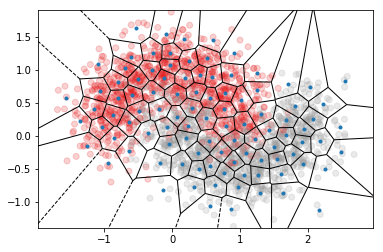

In [5]:
fig, ax = plt.subplots()
kmeans_voronoi_plot(training_data, training_labels, transforms['kmeans'].cluster_centers_, ax)

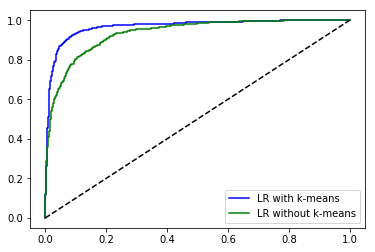

In [6]:
# Plot results
fig, ax = plt.subplots()

# The model with kmeans
pipe_preds = pipe.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, pipe_preds)
ax.plot(fpr, tpr, 'b-', label='LR with k-means')
    
# The model without kmeans
compare_preds = compare.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, compare_preds)
ax.plot(fpr, tpr, 'g-', label='LR without k-means')

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

In [7]:
pipe2 = Pipeline([
    ('feats',FeatureUnion([
        ('trees', RandomTreesEmbedding()),
        ('ID', IdentityFeaturizer())
    ])),
    ('clf', LogisticRegressionCV())
])

pipe2.fit(training_data, training_labels)

Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('trees', RandomTreesEmbedding(max_depth=5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [8]:
# Just to make sure it's clear what this does:
transformed = pipe2.named_steps['feats'].transform(training_data)
transformed.shape

(2000, 286)

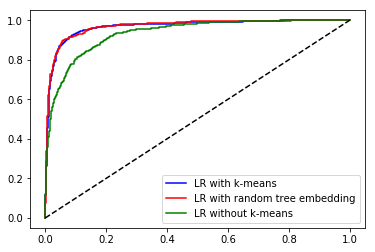

In [9]:
# Plot results
fig, ax = plt.subplots()

# The model with kmeans
pipe_preds = pipe.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, pipe_preds)
ax.plot(fpr, tpr, 'b-', label='LR with k-means')

# The model with trees
pipe2_preds = pipe2.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, pipe2_preds)
ax.plot(fpr, tpr, 'r-', label='LR with random tree embedding')
    
# The model without kmeans
compare_preds = compare.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, compare_preds)
ax.plot(fpr, tpr, 'g-', label='LR without k-means')

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

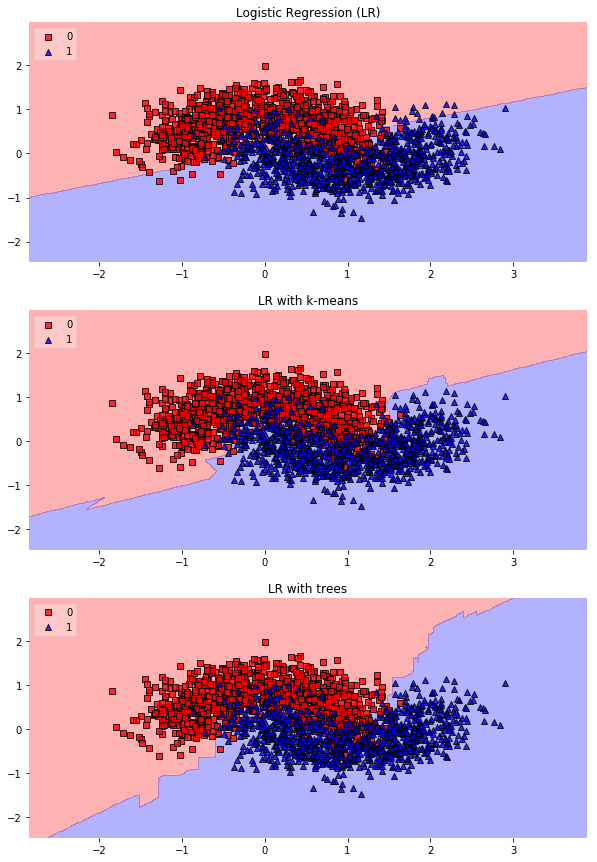

In [10]:
gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(10, 15))

labels = ['Logistic Regression (LR)',
          'LR with k-means',
          'LR with trees']

for clf, lab, i in zip([compare, pipe, pipe2],
                         labels,
                         range(len(labels))):
    ax = plt.subplot(gs[i, 0])
    fig = plot_decision_regions(X=test_data, y=test_labels,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()